## Import Libraries

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob
%matplotlib notebook

---

## 5.1 Data Preparation

In [2]:
#1. List all file name in face image path
filenames = glob.glob('./Data/face_mini/*/*.jpg')
all_imgs = []


#2. Load image files and Resze (h, w,ch) -> h = w < 100, ch = 3 (R, G, B)
for i in range(len(filenames)):
    img = image.load_img(filenames[i], target_size=(80,80), interpolation="nearest")
    img = image.img_to_array(img)  #Convert image to an array
    img = img/255                  #Normalized color image
    all_imgs.append(img)


#3. Convert to numpy array
all_images = np.array(all_imgs)


#4. Split data into train and validation data
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.3)

### Show image

<IPython.core.display.Javascript object>


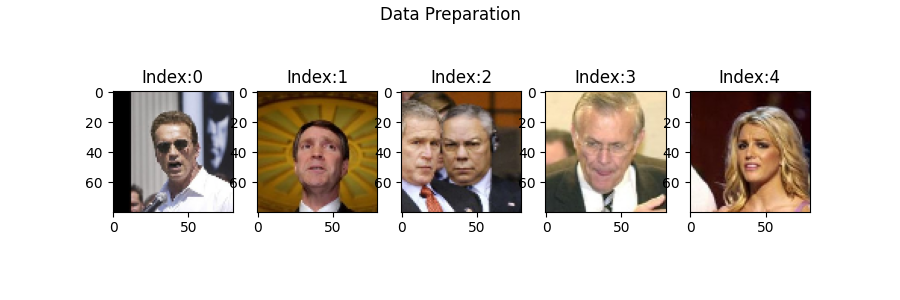

In [3]:
fig = plt.figure(figsize=(9, 3))
fig.suptitle("Data Preparation")
rows = 1
columns = 5

for i in range(5):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(train_x[i])
    plt.title('Index:'+ str(i))
plt.show()

## 5.2 Add Noise

In [4]:
#1. Add noise
noise_factor = 0.25


#2. Define noise parameter
noise_distribution = 'normal'
noise_mean = 0
noise_std = 1


#3. Use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=train_x.shape))
x_val_noisy = val_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=val_x.shape))

### Show Noise Image

<IPython.core.display.Javascript object>


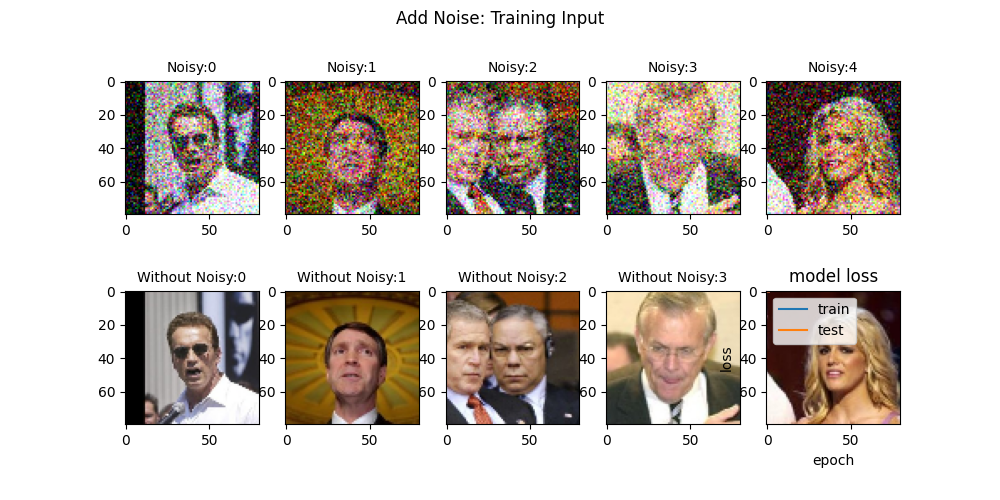

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [5]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Add Noise: Training Input")
rows = 2
columns = 5

for i in range(5):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_train_noisy[i])
    plt.title('Noisy:'+ str(i), fontsize=10)
    
for i in range(5):
    fig.add_subplot(rows, columns, 6+i)
    plt.imshow(train_x[i])
    plt.title('Without Noisy:'+ str(i), fontsize=10)

plt.show()

---

## 5.3 Autoencoder Model

### Autoencoder Architecture

In [6]:
#1. Define Encoder Architecture
input_img = Input(shape=(80, 80, 3))

x1 = Conv2D(256, (3,3), activation='relu', padding='same')(input_img)
x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x1)
x2 = MaxPool2D((2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

#2. Define Decoder Architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3,3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3,3), padding='same')(x1)

#3. Define Optimizer setting
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')  #mse = Mean Square Error
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 128)       295040    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 64)        36928     
                                                             

### Training Autoencoder Model

In [7]:
#1. Training Parameter
epoch = 2
batch_size = 8
early_stopper = EarlyStopping(monitor='loss', patience=3)

#2. Start Training
history = autoencoder.fit(x_train_noisy, 
                          train_x,
                          epochs = epoch,
                          batch_size = batch_size,
                          shuffle = True,
                          validation_data = (x_val_noisy, val_x),
                          callbacks=[early_stopper])


#3. Test autoencoder model with validation
predictions = autoencoder.predict(x_val_noisy)

Epoch 1/2
281/281 [==============================] - 5015s 18s/step - loss: 0.0219 - val_loss: 0.0053
Epoch 2/2
281/281 [==============================] - 5006s 18s/step - loss: 0.0048 - val_loss: 0.0043


(None, 80, 80, 3)


<IPython.core.display.Javascript object>


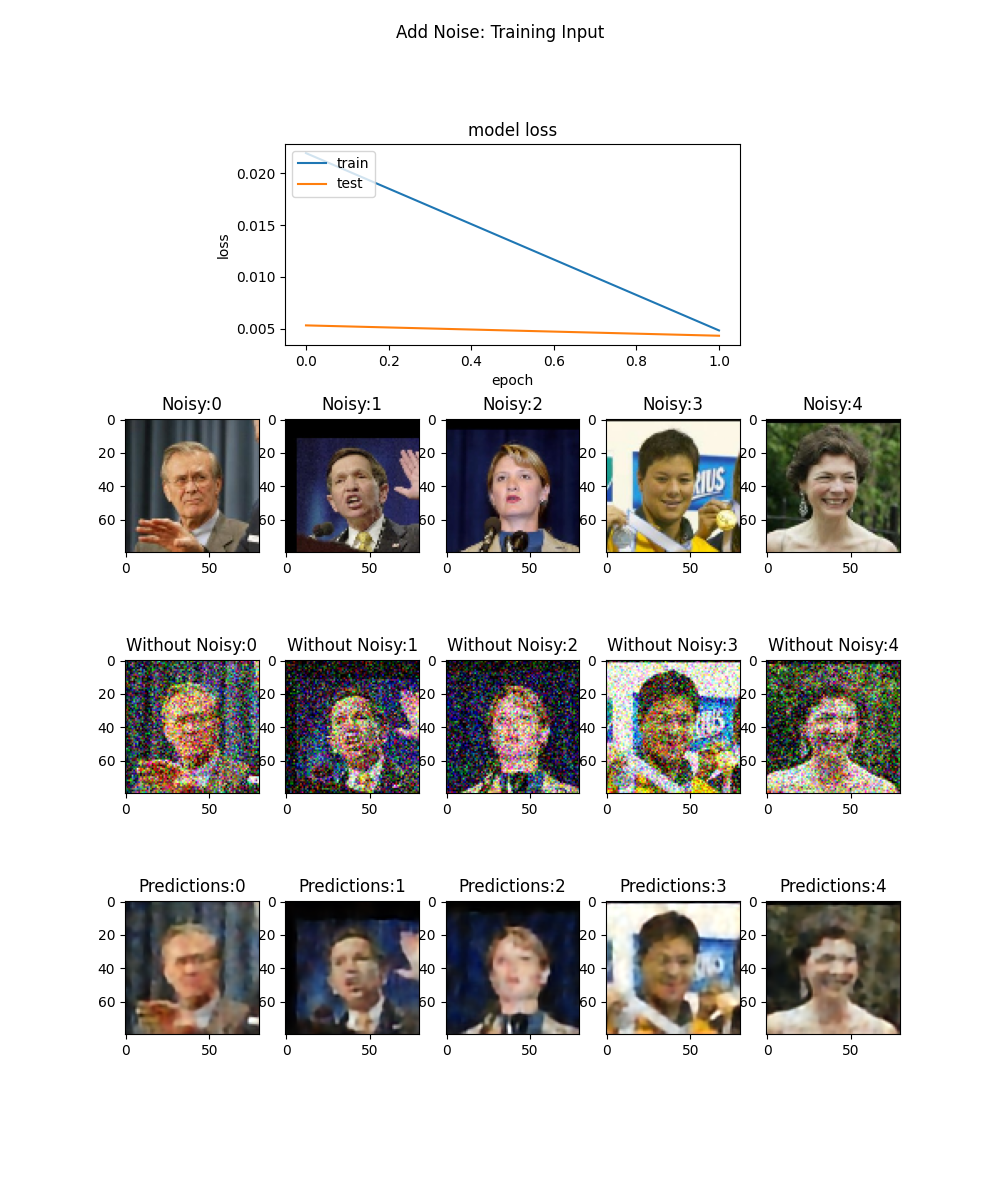

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [57]:
fig = plt.figure(figsize=(10, 12))
fig.suptitle("Add Noise: Training Input")
rows = 4
columns = 5

#4. View loss from history
fig.add_subplot(4, 5, (2,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#x value
for i in range(5):
    fig.add_subplot(rows, columns, 5+i+1)
    plt.imshow(val_x[i])
    plt.title('Noisy:'+ str(i))

#x value noisy
for i in range(5):
    fig.add_subplot(rows, columns, 11+i)
    plt.imshow(x_val_noisy[i])
    plt.title('Without Noisy:'+ str(i))

#predictions
for i in range(5):
    fig.add_subplot(rows, columns, 16+i)
    plt.imshow(predictions[i])
    plt.title('Predictions:'+ str(i))

plt.show()